# Logistic regression prediction threshold analysis
Analysis of one vs rest logistic regression model qulaity at different prediction threshold.

Motivation: Despite some targets having relatively low F score they also have high ROC AUC score. It was thus assessed what happens to F score when using different prediction thresholds.

In [283]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)


import pandas as pd
import numpy as np
#from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score,auc,roc_curve, precision_recall_curve
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification
import sklearn.preprocessing as pp
import altair as alt
#alt.renderers.enable('notebook')
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

import stages_DE.stages_library
import importlib
importlib.reload(stages_DE.stages_library)

from networks.functionsDENet import loadPickle,savePickle
from stages_DE.stages_library import PHENOTYPES, summary_classification, summary_classification_print_sort, scatter_catgory


In [176]:
proteus=True
if proteus:
    pathClassification = '/home/khrovatin/timeTrajectoriesNet/data/stages/classification/'
    dataPath= '/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
else:
    pathClassification = '/home/karin/Documents/timeTrajectories/data/stages/classification/'

## Model

Data used for modeling: samples with phenotypic annotations, excluding target yem due to low number of positive samples, genes (features) that are not constant. For prediction data was split into training and test set, with AX4 data used for testing, and scaled to interval [0,1]. 

In [177]:
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [185]:
# Retain only samples with annotations
Y = conditions[(conditions[PHENOTYPES] != 0).any(axis=1)]
X = genes[Y.Measurment].T.values

In [186]:
# Remove targets with too little positive samples
order=PHENOTYPES.copy()
order.remove('yem')
# Prepare target data
Y_samples=Y['Measurment'].values
Y = Y[order].values
conditions_model=conditions.copy()
conditions_model.index=conditions_model['Measurment']
conditions_model=conditions_model.loc[Y_samples,]

In [187]:
# Remove constant features
X=X[:,(X.std(axis=0)!=0)]

Model: OvR weighted based on label proportion within targets. Individual strains are used as test sets.

In [ ]:
# Make model with each strain used as test
fold_results=dict()
for fold in conditions_model['Strain'].unique():
    print(fold)
    train_index=(conditions_model['Strain']!=fold).values
    test_index=(conditions_model['Strain']==fold).values
    X_train,X_test=X[train_index],X[test_index]
    Y_train,Y_test=Y[train_index],Y[test_index]
    
    #Scale X features to [0,1], use X_train scaller to also scale X_test
    scaler = pp.MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    #Model
    classifier = OneVsRestClassifier(estimator=LogisticRegression(n_jobs=20,  solver='saga',penalty='none',
                                                              class_weight='balanced'),
                                 n_jobs=Y_train.shape[1] ).fit(X_train,Y_train)
    
    Y_p = classifier.predict_proba(X_test)
    
    # ROC analysis addapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    #Y_score = classifier.decision_function(X_test)
    # Compute ROC curve and ROC area for each class

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #precision=dict()
    #recall=dict()
    #threshold=dict()
    for i in range(Y_train.shape[1]):
        phenotype=order[i]
        fpr[phenotype], tpr[phenotype], _ = roc_curve(Y_test[:, i], Y_p[:, i])
        roc_auc[phenotype] = auc(fpr[phenotype], tpr[phenotype])
        #precision[phenotype],recall[phenotype],threshold[phenotype]=precision_recall_curve(Y_test[:,i],Y_p[:,i])
    
    # Calculation of precision, recall, and F score at different prediction thresholds
    prfs_all=pd.DataFrame()
    step=0.05
    for threshold in np.arange(0, 1+step, step):
        Y_class=Y_p.copy()
        Y_class[Y_class>threshold]=1
        Y_class[Y_class<=threshold]=0
        prfs=pd.DataFrame(precision_recall_fscore_support(Y_test, Y_class),index=['precision','recall','F_score','support']).T
        prfs['Stage']=order
        prfs['Threshold']=[threshold]*prfs.shape[0]
        prfs_all=prfs_all.append(prfs)
        
    fold_results[fold]={'fpr':fpr,'tpr':tpr,'roc_auc':roc_auc,'prfs_all':prfs_all}

## Prediction threshold evaluation
Below are ROC-AUC and F-score vs prediction threshold plots of the model. This shows if model performance could be improved by using a different prediction threshold. 


### Evaluate model performance of all stages in a single strain

Below is the selected strain:

In [297]:
strain='AX4'

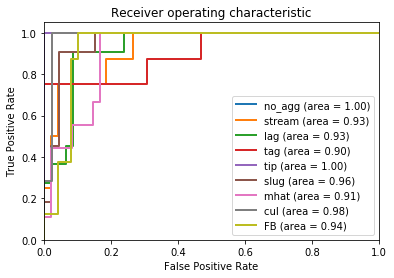

In [298]:
# ROC plot for individual targets
plt.figure()
lw = 2
colour_dict={}
for stage in order:
    p=plt.plot(fold_results[strain]['fpr'][stage], fold_results[strain]['tpr'][stage],
         lw=lw, label=stage+' (area = %0.2f)' % fold_results[strain]['roc_auc'][stage])
    colour_dict[stage]=p[0].get_color()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
a=plt.legend(loc="lower right")

In [299]:
# Plots of model quality metric at different prediction thresholds
display(alt.Chart(fold_results[strain]['prfs_all']).mark_line().encode(x='Threshold',y='F_score',
        color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))
#display(alt.Chart(prfs_all).mark_line().encode(x='Threshold',y='precision',
#        color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))
#display(alt.Chart(prfs_all).mark_line().encode(x='Threshold',y='recall',
#       color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))

alt.Chart(...)

In [ ]:
# Precision vs recall - would be better to use precision and recall caluclated when these metric change 
# (from sklearn, could be caulculated in the ROC code) instead of this one that calculates metrics based on 
# pre-defined thresholds
#display(alt.Chart(prfs_all.sort_values('recall')).mark_line().encode(x='recall',y='precision',
#        color=alt.Color('Stage',scale=alt.Scale(domain=list(colour_dict.keys()),range=list(colour_dict.values())))))

### Evaluate model performance of a single target across strains

Below is the selecte target (developmental stage):

In [304]:
target='FB'

In [305]:
# ROC plot for individual targets
cmap = list(plt.get_cmap('tab20').colors)
cmap2=list(plt.get_cmap('tab20b').colors)
cmap.extend(cmap2)
strains=conditions_model['Strain'].unique()
colors = cmap[:len(strains)]
colour_dict=dict(zip(strains,colors))

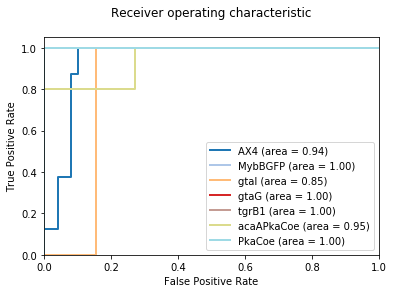

In [306]:
plt.figure()
lw = 2
for fold in strains:
    if not np.isnan(fold_results[fold]['roc_auc'][target]):
        p=plt.plot(fold_results[fold]['fpr'][target], fold_results[fold]['tpr'][target],
             lw=lw, label=fold+' (area = %0.2f)' % fold_results[fold]['roc_auc'][target],c=colour_dict[fold])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic\n')
a=plt.legend(loc="lower right")

In [307]:
prfs_strains=pd.DataFrame()
strains_plot=[]
for strain in strains:
    strain_prfs=fold_results[strain]['prfs_all'].query('Stage =="'+target+'"').copy()
    strain_prfs['Strain']=strain    
    if (strain_prfs['F_score']!=0).any():
        strains_plot.append(strain)
        prfs_strains=prfs_strains.append(strain_prfs)
display(alt.Chart(prfs_strains).mark_line().encode(x='Threshold',y='F_score',
        color=alt.Color('Strain'
              ,scale=alt.Scale(domain=strains_plot,range=[rgb2hex(colour_dict[strain]) for strain in strains_plot])
                                                  )))


alt.Chart(...)

## Conclusion
The default prediction threshold (0.5) is not optimal for all targets (developmental stages). This also depends heavily on the strain. For exanple, for the target stage FB the optimal prediction threshold was in especially moved to smaller numbers for strains with abnormal development/phenotype or presence of multiple developmental stages in the same sample (possible 'dilution' of marker genes RNA). 